In [2]:
import pandas as pd
import numpy as np
import sqlite3 as sqlite
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
path = r'C:\Users\joaol\OneDrive\documentos\Room_temperature_analysis\eplusout.sql'
conn = sqlite.connect(path)

In [7]:
query = """
SELECT t.Month,
    t.Day,
    t.Hour,
    t.Minute,
    value,
    indexGroup,
    keyValue,
    name
FROM (
    SELECT rdd.IndexGroup as indexGroup,
        rdd.KeyValue as keyValue,
        rdd.Name as name,
        round(rd.Value,3) as value,
        rd.TimeIndex
    FROM ReportData rd 
    INNER JOIN ReportDataDictionary rdd ON rd.ReportDataDictionaryIndex = rdd.ReportDataDictionaryIndex 
    WHERE keyValue != "EMS") as rd
inner join Time t on rd.TimeIndex = t.TimeIndex
WHERE t.WarmupFlag = 0
"""


df = pd.read_sql(query, conn)

df.head(3)

,Month,Day,Hour,Minute,value,indexGroup,keyValue,name
0,1,1,0,1,2.003,Zone,Environment,Site Outdoor Air Drybulb Temperature
1,1,1,0,1,1.800,Zone,Environment,Site Wind Speed
2,1,1,0,1,28.083,Zone,Environment,Site Wind Direction


In [8]:
vars = ['Site Outdoor Air Drybulb Temperature',
 'Site Wind Speed',
 'Site Wind Direction',
 'Site Horizontal Infrared Radiation Rate per Area',
 'Site Diffuse Solar Radiation Rate per Area',
 'Site Direct Solar Radiation Rate per Area',
 'Schedule Value',
 'System Node Mass Flow Rate',
 'Zone Mean Air Temperature']

zones = ['Environment', 'NODE 10', 'OFFICE WORK OCC','THERMAL ZONE 1']

In [9]:
interestVars = df[df['name'].isin(vars)]
interestVars = interestVars[interestVars['keyValue'].isin(zones)]
interestVars

,Month,Day,Hour,Minute,value,indexGroup,keyValue,name
0,1,1,0,1,2.003,Zone,Environment,Site Outdoor Air Drybulb Temperature
1,1,1,0,1,1.800,Zone,Environment,Site Wind Speed
2,1,1,0,1,28.083,Zone,Environment,Site Wind Direction
3,1,1,0,1,255.767,Zone,Environment,Site Horizontal Infrared Radiation Rate per Area
4,1,1,0,1,0.000,Zone,Environment,Site Diffuse Solar Radiation Rate per Area
...,...,...,...,...,...,...,...,...
567267,1,7,24,0,0.000,Zone,Environment,Site Diffuse Solar Radiation Rate per Area
567268,1,7,24,0,0.000,Zone,Environment,Site Direct Solar Radiation Rate per Area
567269,1,7,24,0,19.802,Zone,THERMAL ZONE 1,Zone Mean Air Temperature
567274,1,7,24,0,0.000,Zone,OFFICE WORK OCC,Schedule Value


In [10]:
airTemp = interestVars[interestVars['name']=='Zone Mean Air Temperature']
airTemp['datetime'] = pd.to_datetime(airTemp[['Day','Hour','Minute']].assign(year=2017, month=1))
airTemp = airTemp[:-1]

C:\Users\joaol\AppData\Local\Temp\ipykernel_14420\2345029209.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  airTemp['datetime'] = pd.to_datetime(airTemp[['Day','Hour','Minute']].assign(year=2017, month=1))


In [11]:
airTemp = airTemp[['Day','Hour','Minute','name','value','datetime']]
days = airTemp['Day'].unique()
days

array([1, 2, 3, 4, 5, 6, 7], dtype=int64)

In [ ]:
teste = airTemp.groupby(['Day','Hour','name']).mean().reset_index()
teste = teste[teste['Day'] == 2]

fig, axes = plt.subplots(1,1,figsize = (10,5))
axes.plot(teste['datetime'],teste['value'])

In [ ]:
fig, axes = plt.subplots(7,1,figsize = (10,20))

for i, day in enumerate(days):
    selected = airTemp[airTemp['Day'] == day]
    axes[i].plot(selected['datetime'], selected['value'])
    axes[i].set_title(f'Day {day}')
    axes[i].set_ylabel('Air Temp', color='tab:blue')
    axes[i].set_ylim(18.5,21.5)

plt.tight_layout()

In [ ]:
def plotDays(firstVariableName,secondVariableName):
    
    firstVariableData = interestVars[interestVars['name']== firstVariableName]
    firstVariableData['datetime'] = pd.to_datetime(firstVariableData[['Day','Hour','Minute']].assign(year=2017, month=1))
    firstVariableData = firstVariableData[:-1]
    firstVariableData = firstVariableData[['Day','Hour','Minute','name','value','datetime']]
    firstVariableData['HourMinute'] = f"{firstVariableData['Hour']} : {firstVariableData['Minute']}"


    secondVariableData = interestVars[interestVars['name']== secondVariableName]
    secondVariableData['datetime'] = pd.to_datetime(secondVariableData[['Day','Hour','Minute']].assign(year=2017, month=1))
    secondVariableData = secondVariableData[:-1]
    secondVariableData = secondVariableData[['Day','Hour','Minute','name','value','datetime']]
    days = secondVariableData['Day'].unique()

    fig, axes = plt.subplots(7,1,figsize = (10,20))

    for i, day in enumerate(days):
        
        selected = firstVariableData[firstVariableData['Day'] == day]
        airTempPlot, = axes[i].plot(selected['datetime'], selected['value'])
        
        axes[i].set_ylabel(firstVariableName, color='tab:blue')
        axes[i].set_ylim(np.round(firstVariableData['value'].min(),0)-0.5,np.round(firstVariableData['value'].max(),0)+0.5)
        
        ax2 = axes[i].twinx()

        selected = secondVariableData[secondVariableData['Day'] == day]
        sensorPlot, = ax2.plot(selected['datetime'], selected['value'],color = 'red')
        ax2.set_ylabel(secondVariableName, color='red')
        
        ax2.set_ylim(np.round(secondVariableData['value'].min(),0)-0.5,np.round(secondVariableData['value'].max(),0)+0.5)
        ax2.set_title(f'Day {day}')

    fig.legend([airTempPlot, sensorPlot], [firstVariableName, secondVariableName], loc='upper right',bbox_to_anchor = (1.12,0.99))
    fig.suptitle(f'{firstVariableName} x {secondVariableName}',y=1)
    plt.tight_layout()
    
firstVariableName = 'Zone Mean Air Temperature'
secondVariableName = 'System Node Mass Flow Rate'
plotDays(firstVariableName,secondVariableName)
plt.show()

In [ ]:
firstVariableName = 'Zone Mean Air Temperature'
secondVariableName = 'Site Outdoor Air Drybulb Temperature'
plotDays(firstVariableName,secondVariableName)
plt.show()

C:\Users\joaol\AppData\Local\Temp\ipykernel_14420\4183866524.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  firstVariableData['datetime'] = pd.to_datetime(firstVariableData[['Day','Hour','Minute']].assign(year=2017, month=1))
C:\Users\joaol\AppData\Local\Temp\ipykernel_14420\4183866524.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  secondVariableData['datetime'] = pd.to_datetime(secondVariableData[['Day','Hour','Minute']].assign(year=2017, month=1))


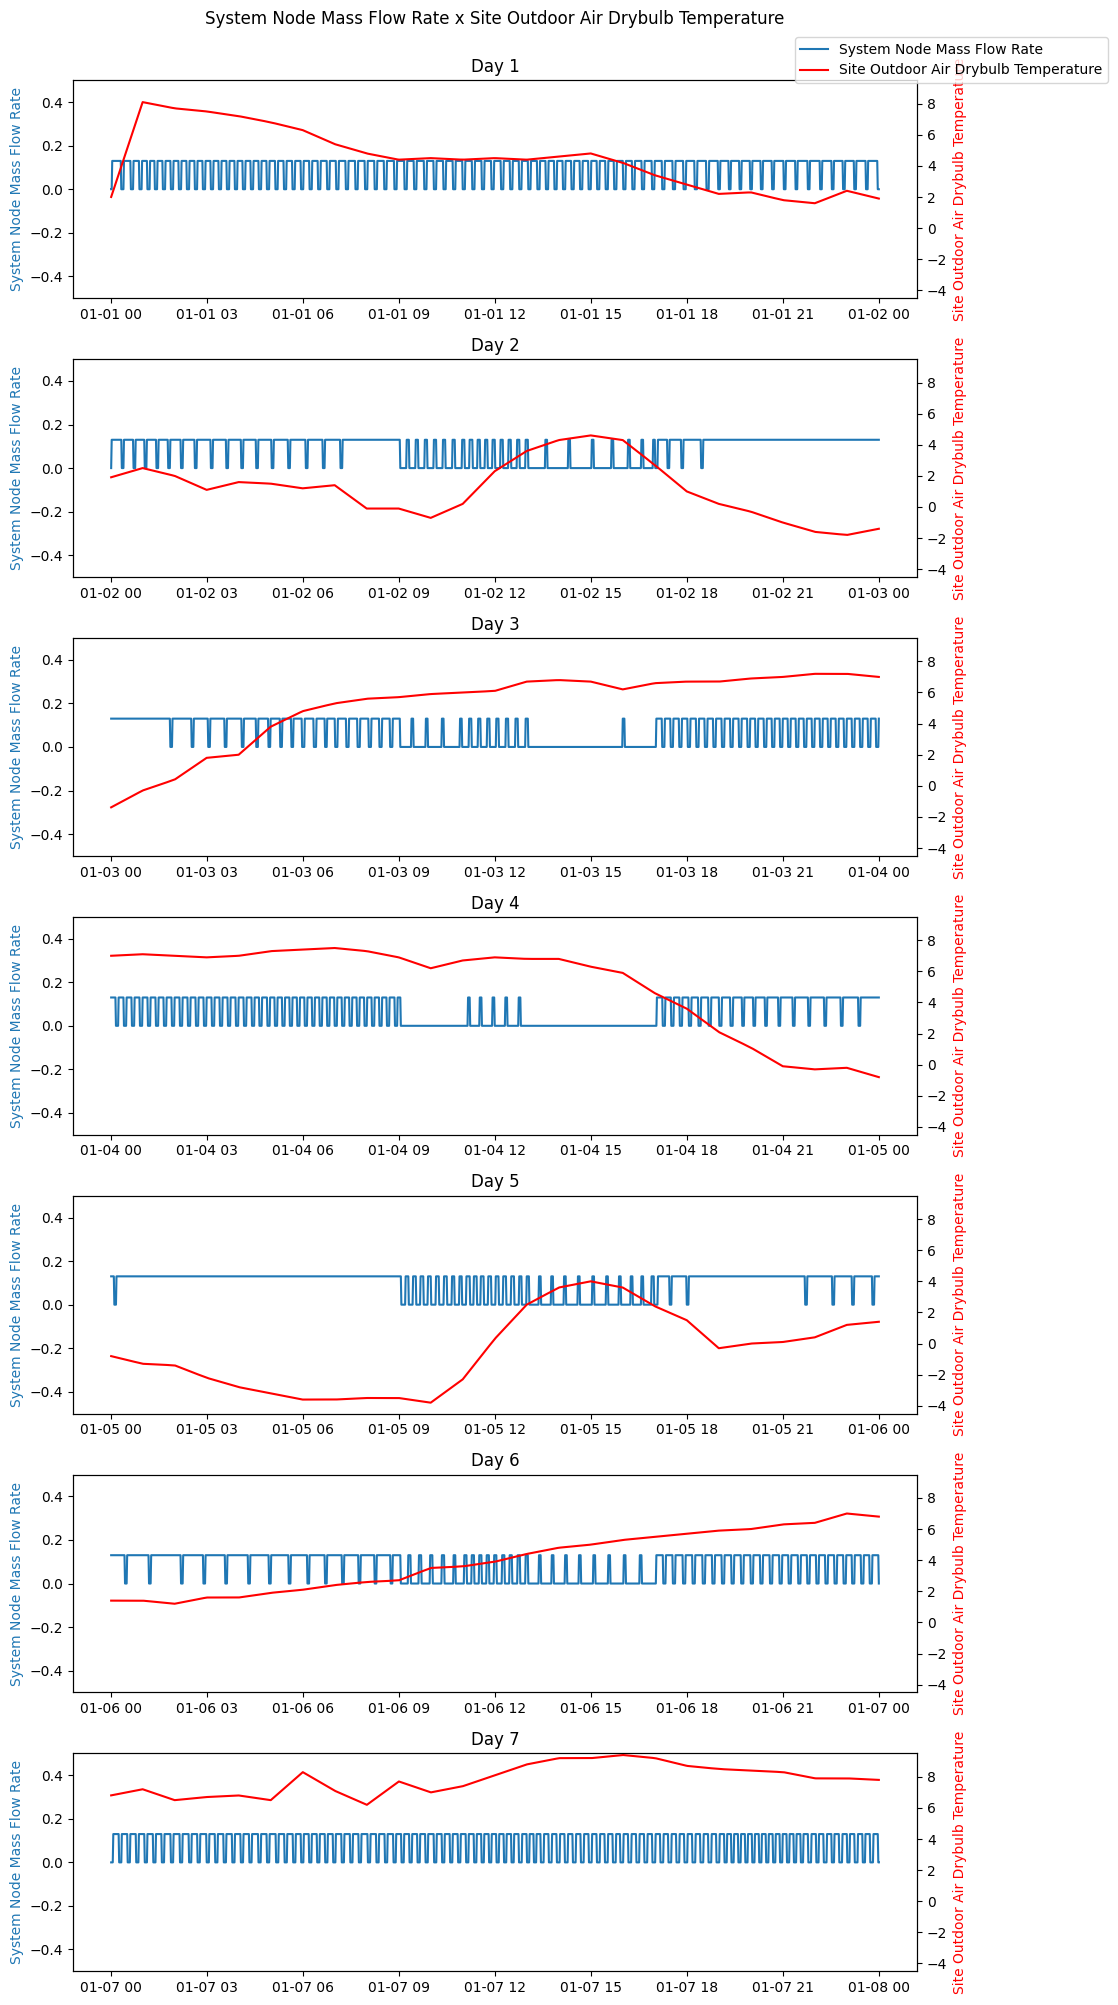

In [110]:
firstVariableName = 'System Node Mass Flow Rate'
secondVariableName = 'Site Outdoor Air Drybulb Temperature'
plotDays(firstVariableName,secondVariableName)
plt.show()

<Axes: xlabel='name', ylabel='name'>

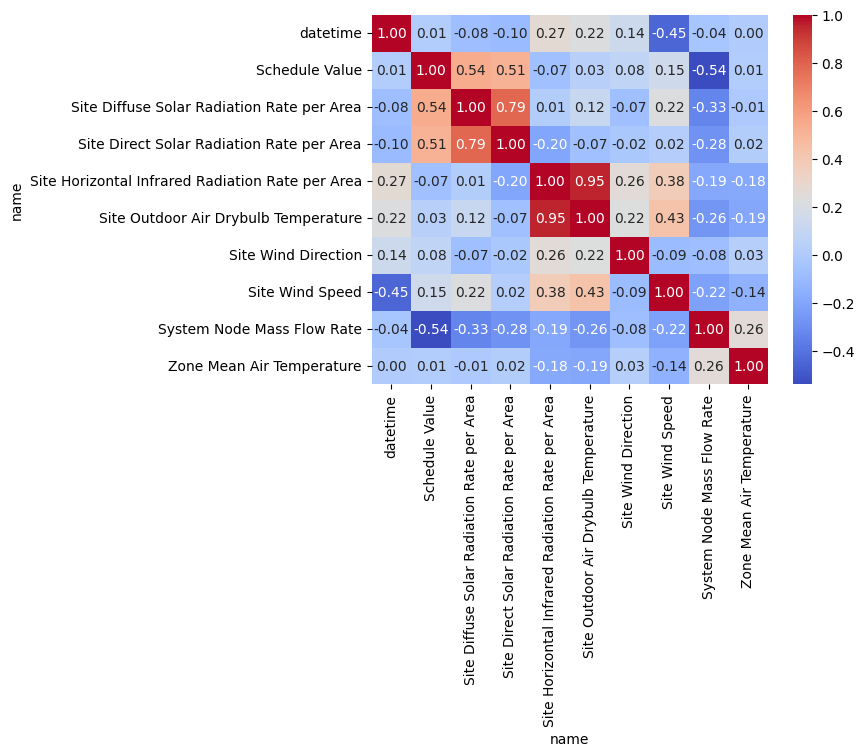

In [96]:
interestVars['datetime'] = pd.to_datetime(interestVars[['Day','Hour','Minute']].assign(year=2017, month=1))
correlationMatrix = interestVars[['datetime','value','name']]
correlationMatrix = correlationMatrix.pivot(index='datetime',columns='name',values='value').reset_index()


correlationMatrix = correlationMatrix.corr()

sns.heatmap(correlationMatrix, annot= True, fmt='.2f',cmap="coolwarm")

